Cloning the github repository to the local directory

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-tk8jdqxl
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-tk8jdqxl
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=dacb6672ba56c4ceae6e551f14057b9e33ec03bef1dac7c2218c5ab118454943
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6azxq6q/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


# Adopting the notebook to run a similar analysis for your country

## Change point analysis to quantify the impact of African government policy interventions to slow the spread of COVID-19

**Importing important libraries**

In [36]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Importing the module from the cloned repository**

In [3]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

Loading the Dataset using RKI Dataset. There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html). In this example we will use the RKI dataset.



In [4]:

jhu = cov19.data_retrieval.JHU() # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


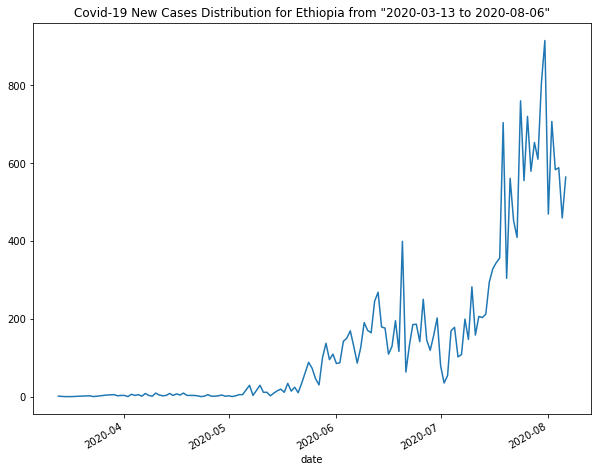

In [6]:
raw = (pd.read_excel("https://github.com/busgandy/10Acad/blob/master/Week%203/eth-covid19-data.xlsx?raw=true"))
raw.set_index('date',inplace=True)
new_case = raw.iloc[:,0]
plt.figure(figsize=[10,8])
plt.title('Covid-19 New Cases Distribution for Ethiopia from "2020-03-13 to 2020-08-06"')
new_case.plot()

In [7]:
# Detecting missing values exitence
new_case[new_case.isnull()] 

Series([], Name: confirmed, dtype: int64)

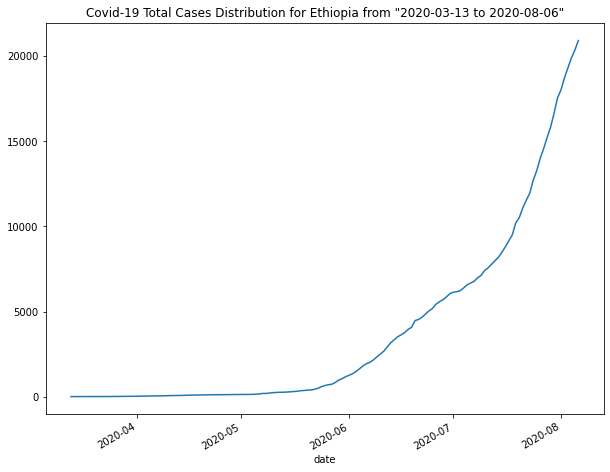

In [8]:
total_cases = raw.iloc[:,1]
plt.figure(figsize=[10,8])
plt.title('Covid-19 Total Cases Distribution for Ethiopia from "2020-03-13 to 2020-08-06"')
total_cases.plot()

In [9]:
# Detecting missing values exitence
total_cases[total_cases.isnull()] 

Series([], Name: confirmed.1, dtype: int64)

INFO     [numexpr.utils] NumExpr defaulting to 2 threads.


Text(0.5, 1.0, 'Covid-19 Confirmed Cases Distribution for Ethiopia')

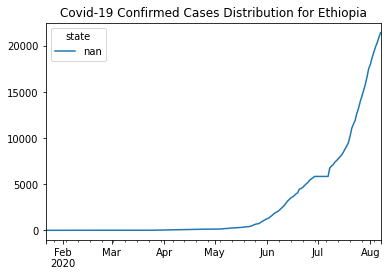

In [21]:
dfeth = jhu.confirmed.Ethiopia
dfeth.plot()
plt.title('Covid-19 Confirmed Cases Distribution for Ethiopia')

In [22]:
dfeth = dfeth.dropna()
dfeth.columns = ['value']
# df.head()
#= 'values'
dfeth = dfeth[dfeth['value']>100]
dfeth.head()

,value
2020-04-18,105
2020-04-19,108
2020-04-20,111
2020-04-21,114
2020-04-22,116


In [23]:
dfeth.tail()

,value
2020-08-03,19289
2020-08-04,19877
2020-08-05,20336
2020-08-06,20900
2020-08-07,21452


Text(0.5, 1.0, 'Covid-19 Death Distribution for Ethiopia')

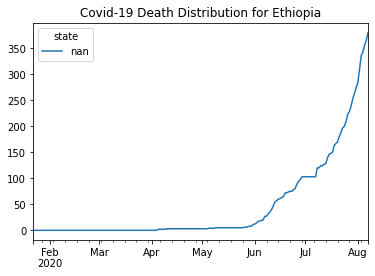

In [24]:
dfdeath = jhu.deaths.Ethiopia
dfdeath.plot()
plt.title('Covid-19 Death Distribution for Ethiopia')

In [25]:
dfdeath.head()

state,NaN
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


In [26]:
dfdeath.tail()

state,NaN
2020-08-03,336
2020-08-04,343
2020-08-05,356
2020-08-06,365
2020-08-07,380


**Splitting the datasets**


1.   Training set includes all dates from the time the community transmission reaches 100 to July 25 2020.
2.   Validation set includes dates from 25 July 2020 to one final date in the covid19 cases data.

In [40]:
# Beginning Date
bd = datetime.datetime(2020, 5, 23)
# End Date
ed = datetime.datetime(2020, 8, 5)

In [42]:
# Setting the variables for new and total cases dates
new_case = new_case[new_case.index > bd]
total_cases = total_cases[total_cases.index > '2020-7-25']

In [12]:
new_cases_obs = new_case[new_case.index < '2020-7-25']
testing_cases = new_case[new_case.index >= '2020-7-25']
new_cases_obs

date
2020-05-24     88
2020-05-25     73
2020-05-26     46
2020-05-27     30
2020-05-28    100
             ... 
2020-07-20    304
2020-07-21    561
2020-07-22    452
2020-07-23    409
2020-07-24    760
Name: confirmed, Length: 62, dtype: int64

### Creating the Model!

Setting the priors for the change points and other configurations

In [14]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [15]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 6, 30)

In [16]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
]

change_points_orig = []


Creating the model! There are default values for most of the function arguments, but we will try to explicitly set all kwargs for the sake of this example.

In [17]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

Functions for access to the model parameter sets

In [18]:
def create_model(change_points, params_model):
  with cov19.model.Cov19Model(**params_model) as this_model:
      # Create the an array of the time dependent infection rate lambda
      lambda_t_log = cov19.model.lambda_t_with_sigmoids(
          pr_median_lambda_0=0.4,
          pr_sigma_lambda_0=0.5,
          change_points_list=change_points,  # The change point priors we constructed earlier
          name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
      )

      # set prior distribution for the recovery rate
      mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

      # This builds a decorrelated prior for I_begin for faster inference.
      # It is not necessary to use it, one can simply remove it and use the default argument
      # for pr_I_begin in cov19.SIR
      prior_I = cov19.model.uncorrelated_prior_I(
          lambda_t_log=lambda_t_log,
          mu=mu,
          pr_median_delay=pr_delay,
          name_I_begin="I_begin",
          name_I_begin_ratio_log="I_begin_ratio_log",
          pr_sigma_I_begin=2,
          n_data_points_used=5,
      )

      # Use lambda_t_log and mu to run the SIR model
      new_cases = cov19.model.SIR(
          lambda_t_log=lambda_t_log,
          mu=mu,
          name_new_I_t="new_I_t",
          name_I_t="I_t",
          name_I_begin="I_begin",
          pr_I_begin=prior_I,
      )

      # Delay the cases by a lognormal reporting delay
      new_cases = cov19.model.delay_cases(
          cases=new_cases,
          name_cases="delayed_cases",
          name_delay="delay",
          name_width="delay-width",
          pr_mean_of_median=pr_delay,
          pr_sigma_of_median=0.2,
          pr_median_of_width=0.3,
      )

      # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
      # Also adds the "new_cases" variable to the trace that has all model features.
      new_cases = cov19.model.week_modulation(
          cases=new_cases,
          name_cases="new_cases",
          name_weekend_factor="weekend_factor",
          name_offset_modulation="offset_modulation",
          week_modulation_type="abs_sine",
          pr_mean_weekend_factor=0.3,
          pr_sigma_weekend_factor=0.5,
          weekend_days=(6, 7),
      )

      # Define the likelihood, uses the new_cases_obs set as model parameter
      cov19.model.student_t_likelihood(new_cases)
  return this_model

In [19]:
mod_a = create_model(change_points, params_model)
mod_b = create_model(change_points_orig, params_model)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model

**MCMC sampling**

After the model is built, it is sampled using an MCMC sampler. The number of parallel runs can be set with the argument cores=. In particular, due to a bug in Theano, Windows users should set cores=1. The sampling can take a long time.

In [20]:
tr_a = pm.sample(model=mod_a,cores= 1, tune=50, draws=100, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b,cores= 1, tune=50, draws=100, init="advi+adapt_diag")
#trace = pm.sample(model=this_model, tune=100, draws=200, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 447.69:  12%

# **Plotting**
Plotting tools are rudimentary right now. But one can always write custom plotting function by accessing the samples stored in the trace.

### **Distributions**

Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'transient_day_1', 'transient_len_1_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


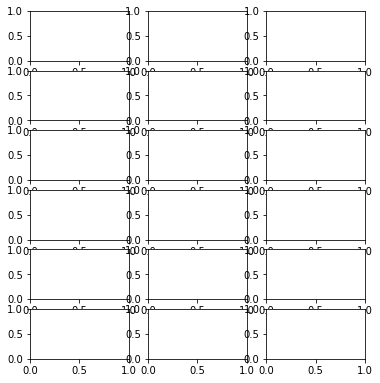

In [27]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = mod_a.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [29]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1"]#, "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(mod_a, tr_a, key, ax=axes[i, 0])

In [30]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        # "transient_day_2",
        # "transient_day_3",
    ]
):
    cov19.plot._distribution(mod_a, tr_a, key, ax=axes[i, 1])

In [31]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1"]#, "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(mod_a, tr_a, key, ax=axes[i + 2, 2])

### **Timeseries**
Timeseries overview, for now needs an offset variable to get cumulative cases

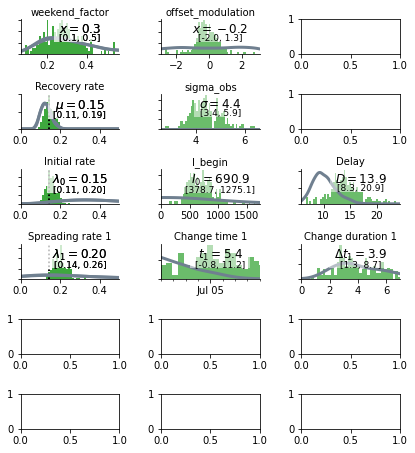

In [32]:
fig.tight_layout()
fig #To print in jupyter notebook

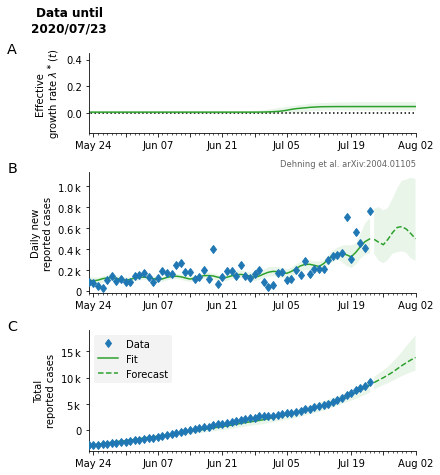

In [33]:
fig, axes = cov19.plot.timeseries_overview(mod_a, tr_a, offset=-3000)

In [37]:
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True

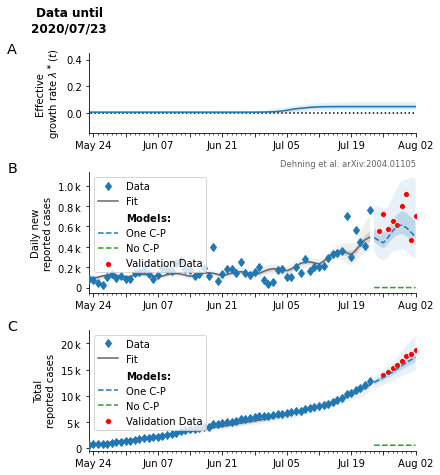

In [38]:
fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=jhu.get_total(country="Ethiopia", data_begin=bd, data_end=ed)[0],
    forecast_label="One C-P",
    forecast_heading=r"$\bf Models\!:$",
    add_more_later=True,
    color="tab:blue",
)
fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=jhu.get_total(country="Ethiopia", data_begin=bd, data_end=ed)[0],
    forecast_label="No C-P",
    color="tab:green",
)
sns.scatterplot(x=testing_cases.index.tolist(), y=testing_cases.tolist(),color='red', ax=axes[1],label='Validation Data')
sns.scatterplot(x=total_cases.index.tolist(), y=total_cases.tolist(),color='red', ax=axes[2],label='Validation Data')



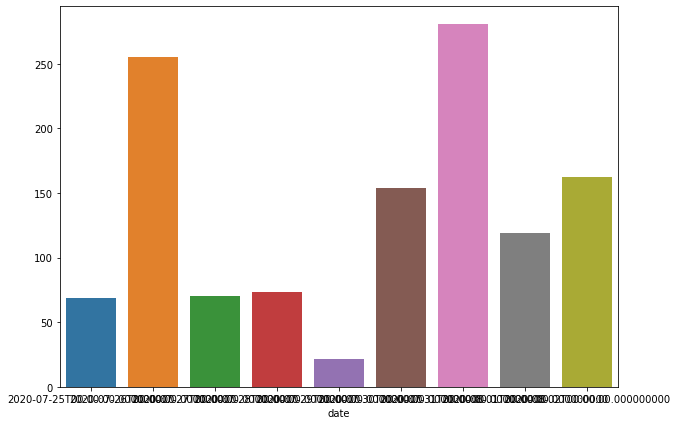

In [39]:
# This is to show the errors for each day
y, x = cov19.plot._get_array_from_trace_via_date(
                mod_a, tr_a, "new_cases", datetime.datetime(2020,7,25), datetime.datetime(2020,8,2)
            )
predicted=y.mean(axis=0)
expected = testing_cases[testing_cases.index<'2020-08-03'].tolist()
forecast_errors = [abs(expected[i]-predicted[i]) for i in range(len(predicted))]


plt.figure(figsize=(10,7))
sns.barplot(x=testing_cases[testing_cases.index<'2020-08-03'].index, y=np.array(forecast_errors))



## Finding the dates where your Ethiopia introduced the following policies.

Using Oxford COVID tracker & IMF policy tracker, [here](https://www.imf.org/en/Topics/imf-and-covid19/Policy-Responses-to-COVID-19). 



1. Banning major gatherings:
    2020,4,8 
2. School closures:
    2020,3,14
3. Required social distancing

4. Mask wearing mandatory
    
5. Relaxing the previous rules
    2020,06,30



